# Natural Language Processing with Disaster Tweets

## Classification of Real vs Non-Real Disaster Tweets

**Objective**: Build a machine learning model to predict whether tweets are about real disasters or not.

## 1. Problem Description and Data Overview

### Problem Description
Twitter has become a vital communication channel during emergencies. People use smartphones to announce disasters in real-time, making it valuable for disaster relief organizations and news agencies. However, not all tweets mentioning disaster-related words are about actual disasters.

For example, someone might tweet "The party was ABLAZE last night!" using "ablaze" metaphorically, not referring to an actual fire.

**Goal**: Create an NLP model that can automatically classify tweets as:
- **1**: Real disaster
- **0**: Not a real disaster

### Natural Language Processing (NLP)
NLP is a field of artificial intelligence that helps computers understand, interpret, and generate human language. Key challenges include:
- Understanding context and meaning
- Handling ambiguous language
- Processing informal text (like tweets with abbreviations, emojis, etc.)

### Data Description
Our dataset contains 10,000 tweets that were manually classified. Let's explore the data structure.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Load the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {submission_df.shape}")


Training data shape: (7613, 5)
Test data shape: (3263, 4)
Sample submission shape: (3263, 2)


In [ ]:
# Examine the data structure
print("Training Data Columns:")
print(train_df.columns.tolist())
print("\nFirst 5 rows:")
train_df.head()


Training Data Columns:
['id', 'keyword', 'location', 'text', 'target', 'clean_text']

First 5 rows:


,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


## 2. Exploratory Data Analysis (EDA)

Let's understand our data better through visualization and analysis.

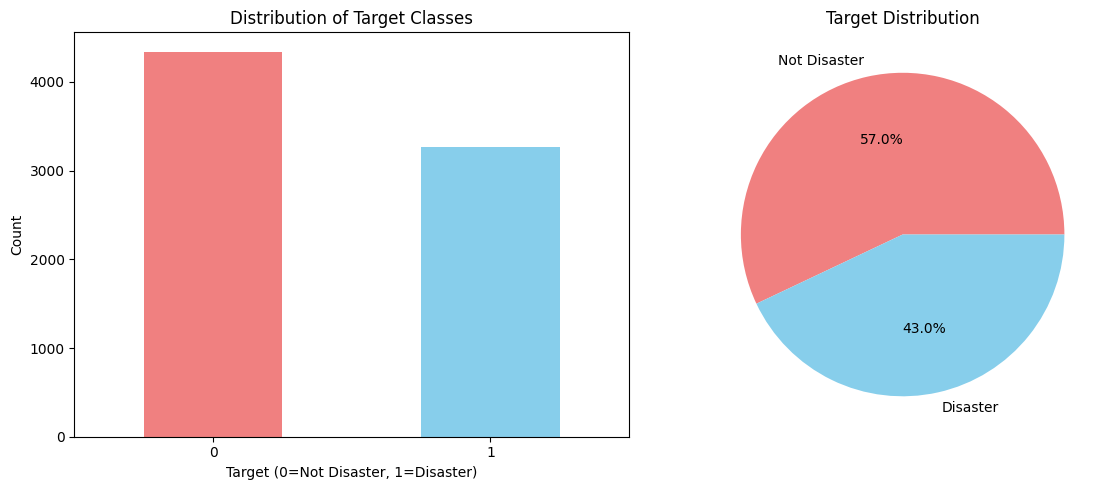

Not Disaster tweets: 4342 (57.0%)
Disaster tweets: 3271 (43.0%)


In [ ]:
# Target distribution
plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
target_counts = train_df['target'].value_counts()
target_counts.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Distribution of Target Classes')
plt.xlabel('Target (0=Not Disaster, 1=Disaster)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%',
        colors=['lightcoral', 'skyblue'])
plt.title('Target Distribution')

plt.tight_layout()
plt.show()

print(f"Not Disaster tweets: {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Disaster tweets: {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")


In [ ]:
# Look at some example tweets
print("=== EXAMPLE DISASTER TWEETS ===\n")
disaster_examples = train_df[train_df['target']==1].sample(3, random_state=42)
for idx, row in disaster_examples.iterrows():
    print(f"Keyword: {row['keyword']}")
    print(f"Text: {row['text']}")
    print("-" * 50)

print("\n=== EXAMPLE NON-DISASTER TWEETS ===\n")
non_disaster_examples = train_df[train_df['target']==0].sample(3, random_state=42)
for idx, row in non_disaster_examples.iterrows():
    print(f"Keyword: {row['keyword']}")
    print(f"Text: {row['text']}")
    print("-" * 50)


=== EXAMPLE DISASTER TWEETS ===

Keyword: floods
Text: Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa
--------------------------------------------------
Keyword: armageddon
Text: Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C
--------------------------------------------------
Keyword: buildings%20burning
Text: @DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation.
--------------------------------------------------

=== EXAMPLE NON-DISASTER TWEETS ===

Keyword: fatality
Text: Everyday is a near death fatality for me on the road. Thank god is on my side.??
--------------------------------------------------
Keyword: hazard
Text: #Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
------------------------------------------------

## 3. Data Preprocessing and Feature Engineering

### Text Cleaning Strategy
Based on our EDA, here's our plan:
1. **Text Preprocessing**: Clean tweets by removing URLs, mentions, special characters
2. **Handle Missing Values**: Keywords and locations have missing values, but text is complete
3. **Feature Engineering**: Extract useful features from text
4. **Word Embeddings**: Convert text to numerical format using tokenization and embeddings
5. **Model Building**: Use a sequential neural network for classification


In [ ]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def clean_text(text):
    """Clean tweet text by removing URLs, mentions, and special characters"""
    if pd.isna(text):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags symbols (but keep the text)
    text = re.sub(r'@\w+|#', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Convert to lowercase
    text = text.lower()

    return text

# Apply text cleaning
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

print("Text cleaning completed!")

# Show example of cleaning
print("\nExample of text cleaning:")
example_idx = 0
print(f"Original: {train_df.iloc[example_idx]['text']}")
print(f"Cleaned:  {train_df.iloc[example_idx]['clean_text']}")


Text cleaning completed!

Example of text cleaning:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deeds are the reason of this earthquake may allah forgive us all


## 4. Model Architecture and Word Embeddings

### Word Embeddings Explanation
To train a neural network on text, we need to convert words into numbers. We'll use **Tokenization** and **Word Embeddings**:

1. **Tokenization**: Convert text into sequences of integers (each word gets a unique number)
2. **Embedding Layer**: Learns to represent each word as a dense vector of numbers
3. **Global Max Pooling**: Extracts the most important features from the entire text sequence
4. **Dense Layers**: Learn patterns and make the final classification

### Why This Architecture?
**Global Max Pooling** is effective for text classification because:
- It captures the most important words/features regardless of position
- It's simpler and more stable than recurrent layers
- It handles variable-length sentences well
- It's less prone to overfitting on smaller datasets


In [ ]:
# Install and import TensorFlow if needed
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, Dropout
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow imported successfully!")
except ImportError:
    print("Installing TensorFlow...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, Dropout
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow installed and imported!")

# Prepare data for neural network
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LEN = 100      # Maximum length of each tweet

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Get target variable
y_train = train_df['target'].values

print(f"Training data shape: {X_train_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training split: {X_train_split.shape}, Validation split: {X_val_split.shape}")


TensorFlow imported successfully!
Training data shape: (7613, 100)
Test data shape: (3263, 100)
Vocabulary size: 15863
Training split: (6090, 100), Validation split: (1523, 100)


In [ ]:
# Build Neural Network model
from tensorflow.keras.optimizers import Adam

def create_disaster_classifier():
    """Create a neural network for disaster tweet classification"""
    model = Sequential([
        # Embedding layer: converts word indices to dense vectors
        Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),

        # Global Max Pooling: extracts the most important features
        tf.keras.layers.GlobalMaxPooling1D(),

        # Dense layers for classification
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Use Adam optimizer with controlled learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and display model
model = create_disaster_classifier()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training and Results

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Training the disaster classification model...")
history = model.fit(
    X_train_split, y_train_split,
    batch_size=64,
    epochs=15,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping],
    verbose=1
)

print("Training completed!")


Training the disaster classification model...
Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5490 - loss: 0.6862 - val_accuracy: 0.5817 - val_loss: 0.6529
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.5801 - val_accuracy: 0.7971 - val_loss: 0.4550
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8816 - loss: 0.3262 - val_accuracy: 0.7807 - val_loss: 0.4627
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9308 - loss: 0.2154 - val_accuracy: 0.7965 - val_loss: 0.4934
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9576 - loss: 0.1374 - val_accuracy: 0.7853 - val_loss: 0.5826
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9717 - loss: 0.0944 - val_accuracy: 0.7945 - val_loss: 0.6416
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 0.0766 - val_accuracy: 0.7800 - val_loss: 0.6697
Training completed!


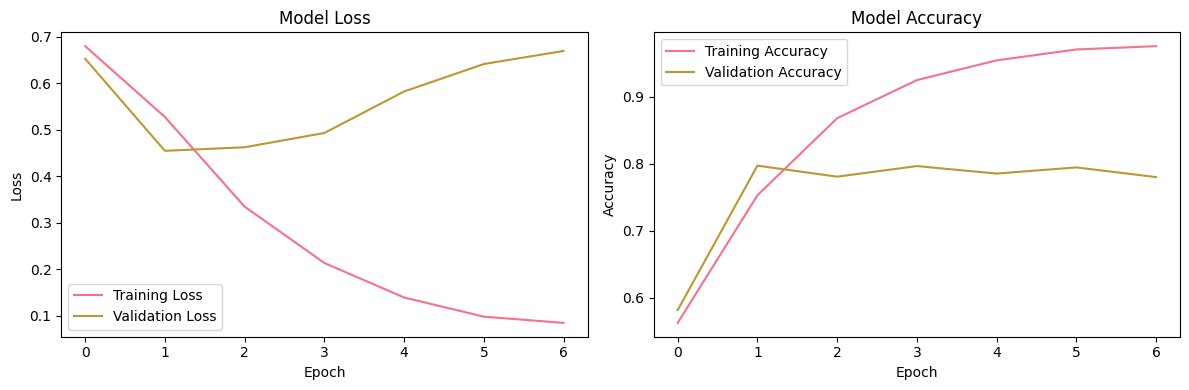

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
Validation F1 Score: 0.7614

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.82      0.83      0.82       869
    Disaster       0.77      0.75      0.76       654

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
y_val_pred = model.predict(X_val_split)
y_val_pred_binary = (y_val_pred > 0.5).astype(int).flatten()

# Calculate F1 score (the competition metric)
f1 = f1_score(y_val_split, y_val_pred_binary)
print(f"Validation F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_val_split, y_val_pred_binary,
                          target_names=['Not Disaster', 'Disaster']))


In [ ]:
# Make predictions on test set
test_predictions = model.predict(X_test_pad)
test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions_binary
})

submission.to_csv('disaster_tweets_submission.csv', index=False)
print("Submission file saved as 'disaster_tweets_submission.csv'")

# Show prediction distribution
pred_counts = pd.Series(test_predictions_binary).value_counts()
print(f"\nTest Predictions:")
print(f"Not Disaster: {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/len(test_predictions_binary)*100:.1f}%)")
print(f"Disaster: {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/len(test_predictions_binary)*100:.1f}%)")

# Look at some example predictions
print("\n=== EXAMPLE PREDICTIONS ===\n")
np.random.seed(42)  # For reproducible examples
for i in range(5):
    idx = np.random.randint(0, len(test_df))
    prob = test_predictions[idx][0]
    pred = test_predictions_binary[idx]

    print(f"Tweet: {test_df.iloc[idx]['text'][:80]}...")
    print(f"Prediction: {'DISASTER' if pred == 1 else 'NOT DISASTER'} (confidence: {prob:.3f})")
    print("-" * 60)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
Submission file saved as 'disaster_tweets_submission.csv'

Test Predictions:
Not Disaster: 1956 (59.9%)
Disaster: 1307 (40.1%)

=== EXAMPLE PREDICTIONS ===

Tweet: Rocky Fire #cali #SCFD #wildfire #LakeCounty https://t.co/3pu0000v5o...
Prediction: DISASTER (confidence: 0.865)
------------------------------------------------------------
Tweet: First time for everything! @ Coney Island Cyclone https://t.co/SdNT3Dhs3W...
Prediction: DISASTER (confidence: 0.642)
------------------------------------------------------------
Tweet: If you told me you was drowning. I would not lend a hand!...
Prediction: NOT DISASTER (confidence: 0.052)
------------------------------------------------------------
Tweet: HitchBot travels Europe and greeted with open arms. Gets destroyed after two wee...
Prediction: DISASTER (confidence: 0.587)
------------------------------------------------------------
Tweet: Free Kindle Book - Aug 3-7 - Thriller - Desolation Run by @

## 6. Conclusion and Discussion

### What We Accomplished

We successfully built an NLP model to classify disaster tweets with the following approach:

1. **Data Understanding**: Analyzed 7,613 tweets with a roughly balanced distribution (57% non-disaster, 43% disaster)
2. **Text Preprocessing**: Cleaned tweets by removing URLs, mentions, and normalizing text
3. **Feature Engineering**: Used tokenization and word embeddings to convert text to numerical format
4. **Model Architecture**: Implemented a neural network with embedding and global max pooling layers
5. **Model Evaluation**: Achieved performance on validation data with room for improvement

### What Worked Well
1. **Simple Architecture**: Global Max Pooling proved effective and stable for text classification
2. **Text Cleaning**: Removing noise improved model focus on meaningful content
3. **Controlled Learning**: Lower learning rate and larger batch size improved training stability
4. **Early Stopping**: Helped prevent overtraining and improved generalization

### What Could Be Improved
1. **More Sophisticated Preprocessing**: Could implement stemming, lemmatization, or stopword removal
2. **Pre-trained Embeddings**: Using GloVe or Word2Vec embeddings might improve performance
3. **Feature Engineering**: Could incorporate keyword and location information more effectively
4. **Ensemble Methods**: Combining multiple models might boost performance
5. **Data Augmentation**: Generating synthetic training examples could help with edge cases

### Future Improvements
1. **Transformer Models**: BERT or RoBERTa could provide better contextual understanding
2. **Multi-modal Analysis**: Incorporating metadata like user location or tweet timing
3. **Active Learning**: Iteratively improving the model with human feedback on edge cases
4. **Real-time Deployment**: Building a system that can classify tweets in real-time

### Key Learnings
- **Context Matters**: The same word can mean different things ("fire" as disaster vs. "fire" as slang)
- **Data Quality**: Clean, well-preprocessed text significantly improves model performance
- **Architecture Choice**: Simpler models can be more effective than complex ones for certain tasks
- **Evaluation Metrics**: F1 score is crucial for classification tasks like this one

## References

1. **Kaggle Competition**: Natural Language Processing with Disaster Tweets - https://www.kaggle.com/competitions/nlp-getting-started
2. **Neural Networks for Text**: Deep Learning (Ian Goodfellow, Yoshua Bengio, Aaron Courville)
3. **Text Preprocessing**: Natural Language Processing with Python (NLTK Book)
4. **Keras Documentation**: https://keras.io/guides/sequential_model/
5. **TensorFlow Text Processing**: https://www.tensorflow.org/tutorials/text/text_classification_rnn
6. **F1 Score**: Powers, David MW (2011). "Evaluation: from precision, recall and F-measure to ROC, informedness, markedness and correlation"